In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import ndimage as ndi

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, plase open you Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.filters import gabor_kernel
from skimage.util import invert
from skimage.exposure import equalize_adapthist

# custom functions
from utils.blockproc import blockproc

In [2]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq=0.11):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

## Exercise 1

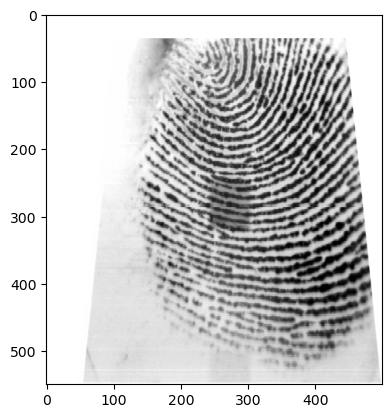

In [3]:
# the image loaded is already [0,1]
img = imread(f'fingerprints/r1.bmp', as_gray=True)
plt.imshow(img, cmap='gray');

using angle 0.7853981633974483, freq=0.15


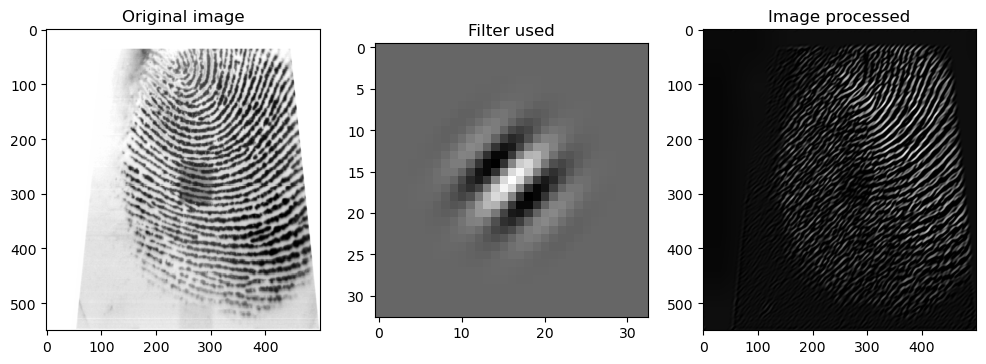

using angle 0.7853981633974483, freq=0.08


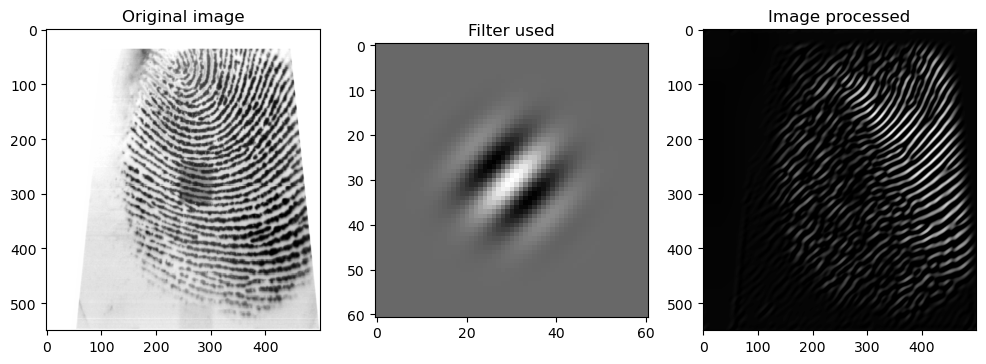

using angle 1.5707963267948966, freq=0.1


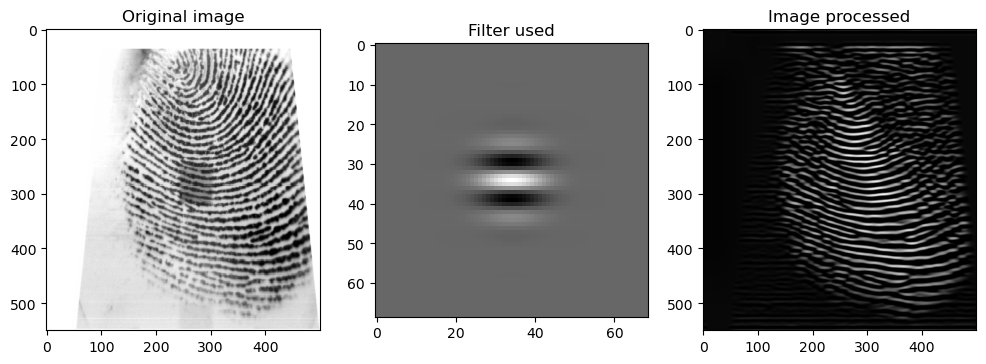

using angle 3.141592653589793, freq=0.1


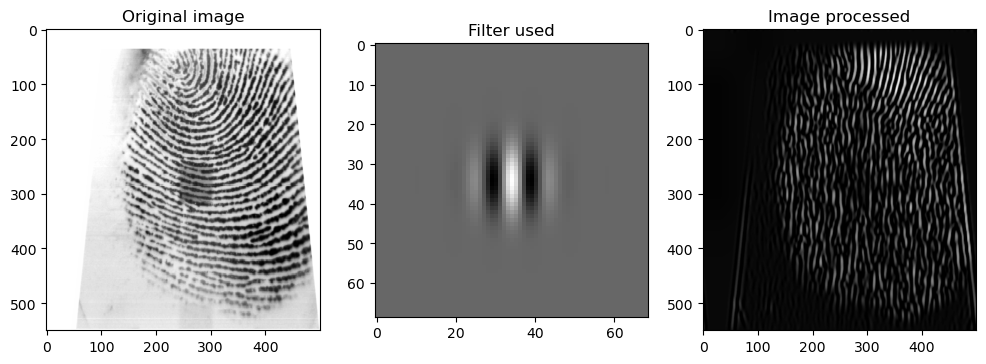

In [4]:
param_set = [(np.pi/4, 0.15),(np.pi/4,0.08),(np.pi/2,0.10),(np.pi,0.10)]
for param in param_set: 
    fi = gabor_template(img, angle=param[0], freq=param[1])
    img_f = gabor_filtering(img, fi)
    print(f"using angle {param[0]}, freq={param[1]}")
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray'); plt.title('Original image')
    plt.subplot(1,3,2)
    plt.imshow(fi, cmap='gray'); plt.title('Filter used')
    plt.subplot(1,3,3)
    plt.imshow(img_f, cmap='gray'); plt.title('Image processed');
    plt.show()

For this exercise we took 4 sets of parameters, for the first 2 sets of data we kept the angle constant and for the next two we kept the frequency constant.

We can see that changing the angle changes the orientation of the ridges, so for example in our case we used pi/4(45 degrees) and pi/2(90 degrees) and you can see that the ridges are orienting themselves accordingly. From altering the frequency we see that increasing and decreasing frequency, increases or decreases the number of ridges identified respectively. 

In our case, the best result yeilded when we used pi/4 and 0.15 as parameters as that image shows most ridges.

## Exercise 2

In [5]:
import cv2 as cv
import numpy as np

from skimage.io import imread, imsave
from skimage.util import img_as_ubyte, invert
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median, gaussian

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.align2 import align2
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from utils.MatchGaborFeat import MatchGaborFeat

In [6]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [7]:
#using a single right thumb print as the probe image (r3)
probe_img = img_as_ubyte(imread('fingerprints/r3.bmp', as_gray=True))
probe_fp = fingerprint_processing(probe_img, block_size=12, threshold=0.1)

In [8]:
#adding the remaining right thumb prints to the gallery
gallery = []

for i in range(1,11):   
    if i!=3:
        gallery_img = img_as_ubyte(imread(f'fingerprints/r{i}.bmp', as_gray=True))
        gallery_fp = fingerprint_processing(gallery_img, block_size=12, threshold=0.1)
        gallery.append(gallery_fp)    
    
print("gallery initialization completed")      

gallery initialization completed


In [9]:
minutiae_match_scores = {}
for i in range(0,len(gallery)):
    print(f"matching with gallery index {i}")

    imSkeletonAlign, minutiaArrayAlign = align2(gallery[i], probe_fp)
    probe_fp['imSkeletonAlign'] = imSkeletonAlign
    probe_fp['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(gallery[i], probe_fp, threshold2=match_threshold)
    minutiae_match_scores[f'fingerprints/r{i}'] = score
    print('score for minutiae: %.4f\n' % (score))

matching with gallery index 0
number of matched minutiae: 15
distance total computed : 65
number of minutiae in input image: 1378
number of minutiae in database image: 150
score for minutiae: 0.0196

matching with gallery index 1
number of matched minutiae: 14
distance total computed : 60
number of minutiae in input image: 1378
number of minutiae in database image: 119
score for minutiae: 0.0187

matching with gallery index 2
number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 127
score for minutiae: 0.0000

matching with gallery index 3
number of matched minutiae: 22
distance total computed : 105
number of minutiae in input image: 2632
number of minutiae in database image: 200
score for minutiae: 0.0155

matching with gallery index 4
number of matched minutiae: 39
distance total computed : 169
number of minutiae in input image: 2795
number of minutiae in database image: 263
score for minutiae: 0.0255

mat

In [16]:
for k,v in minutiae_match_scores.items():
    print(k,round(v,3))
    
with open('minutiae_scores.csv', 'w') as csv_file:  #saves the scores so don't have to re-run the minutiae matching
    writer = csv.writer(csv_file)
    for key, value in minutiae_match_scores.items():
        writer.writerow([key, value])
#read minutiae_scores.csv as a dict instead of running the minutiae matching cell

fingerprints/r0 0.02
fingerprints/r1 0.019
fingerprints/r2 0.0
fingerprints/r3 0.016
fingerprints/r4 0.026
fingerprints/r5 0.014
fingerprints/r6 0.026
fingerprints/r7 0.019
fingerprints/r8 0.0


In [11]:
threshold1 = 0.015
threshold2 = 0.020

minutiae_results = {threshold1: {'fp':0,'fn':0},threshold2: {'fp':0,'fn':0}}
for threshold in [threshold1,threshold2]:
    for k,score in minutiae_match_scores.items():
        if score>=threshold:
            minutiae_results[threshold]['fp']+=1
        else:
             minutiae_results[threshold]['fn']+=1

In [12]:
for k,v in minutiae_results.items():
    print(k, v['fp'], v['fn'])

0.015 6 3
0.02 2 7


## Exercise 3

In [17]:
from skimage.util import img_as_ubyte
from skimage.io import imread
from sklearn.feature_extraction.image import extract_patches_2d
import matplotlib.pyplot as plt

from utils.MatchGaborFeat import MatchGaborFeat

matching with fingerprints/r1
Score using Gabor features: 11.9950
matching with fingerprints/r2
Score using Gabor features: 12.1617
matching with fingerprints/r4
Score using Gabor features: 17.7632
matching with fingerprints/r5
Score using Gabor features: 16.3896
matching with fingerprints/r6
Score using Gabor features: 19.4637
matching with fingerprints/r7
Score using Gabor features: 16.8967
matching with fingerprints/r8
Score using Gabor features: 12.0366
matching with fingerprints/r9
Score using Gabor features: 16.7011
matching with fingerprints/r10
Score using Gabor features: 19.6313


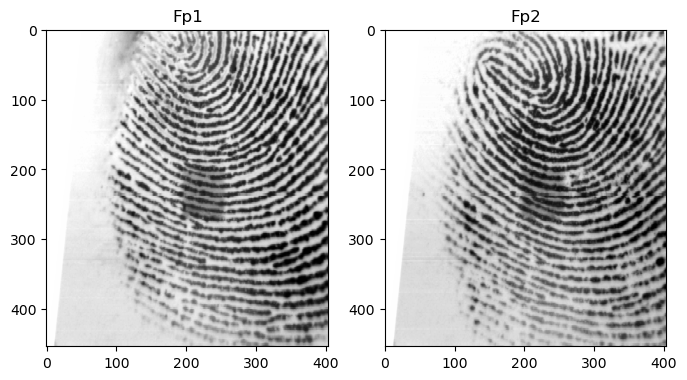

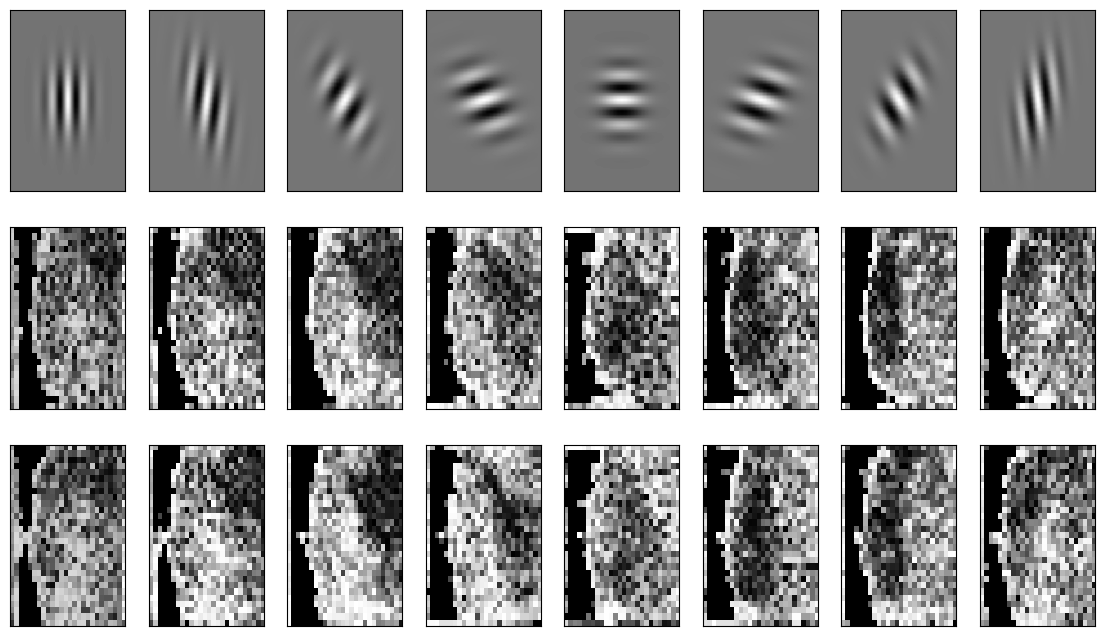

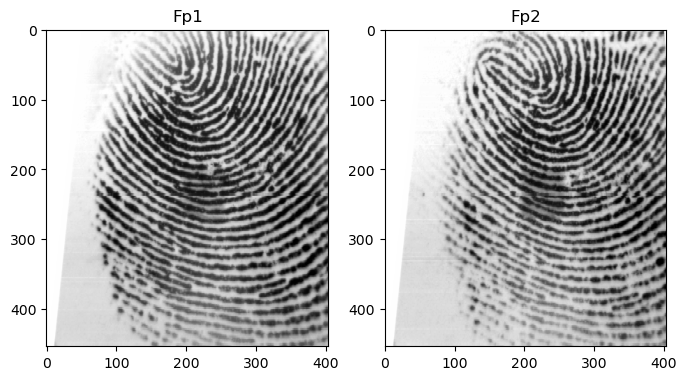

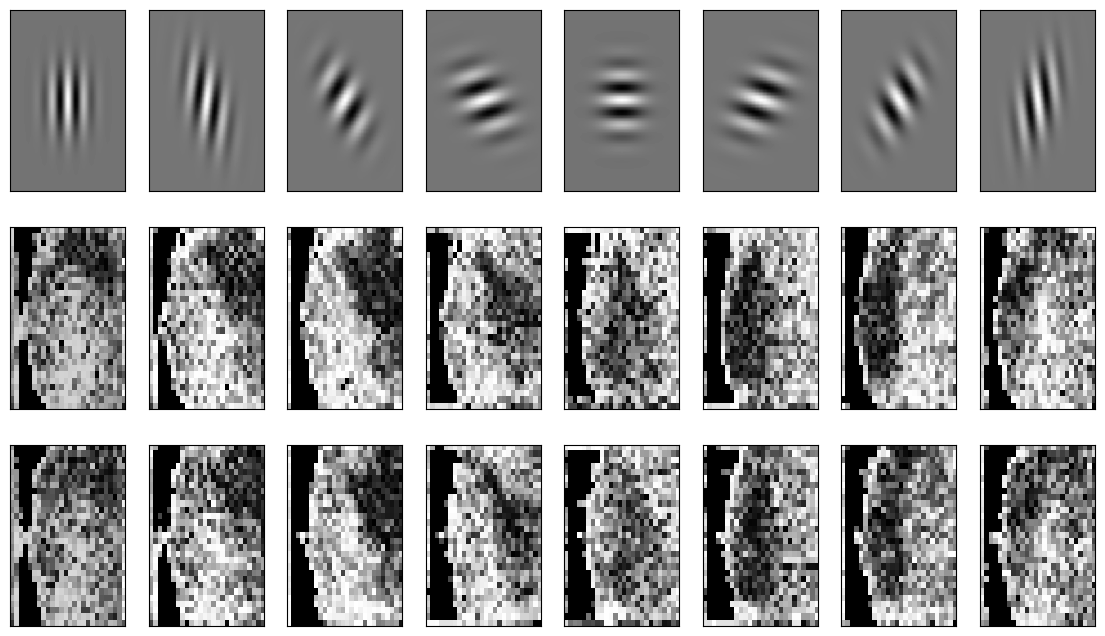

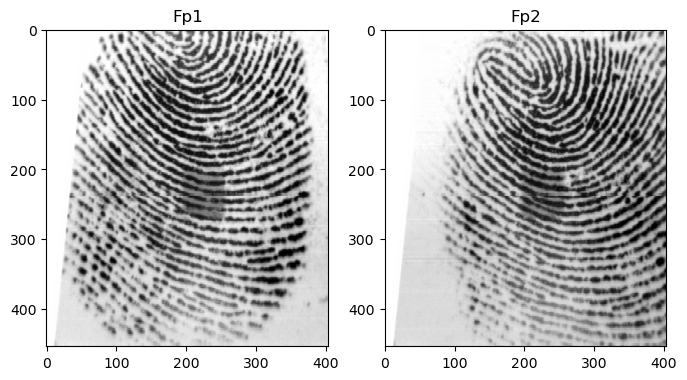

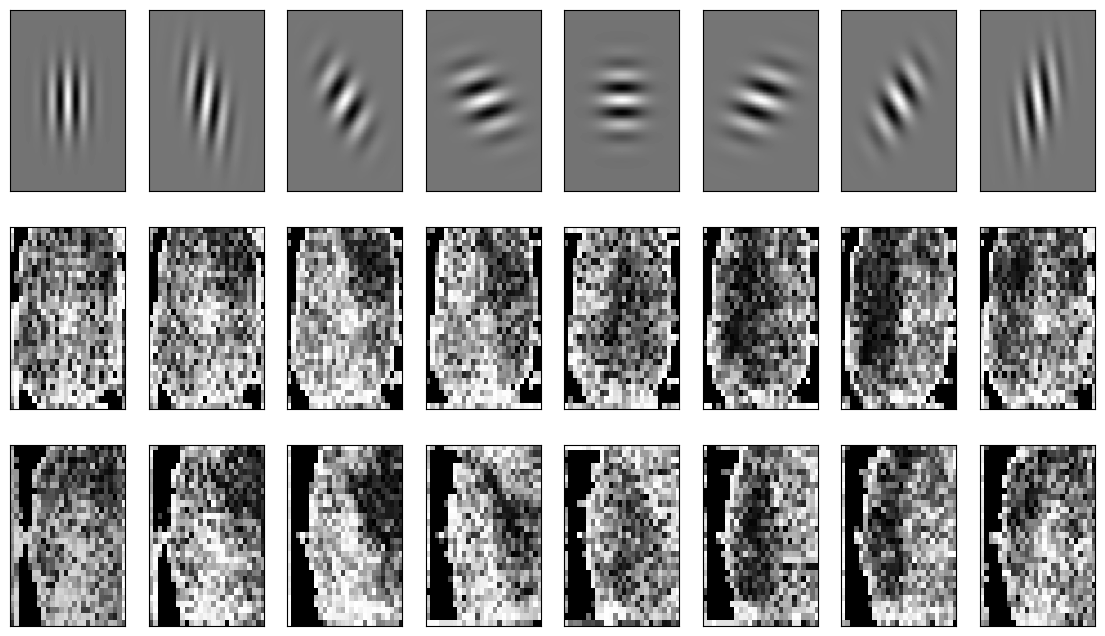

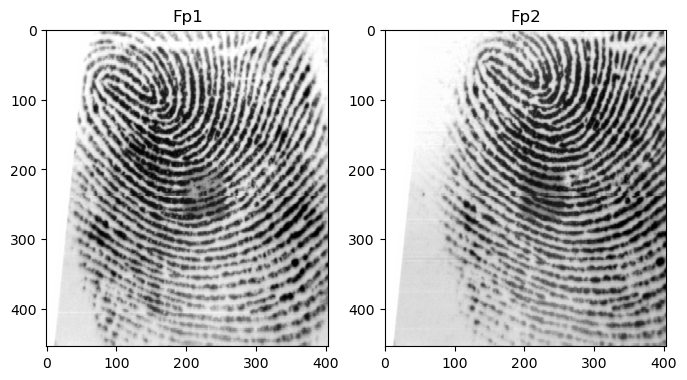

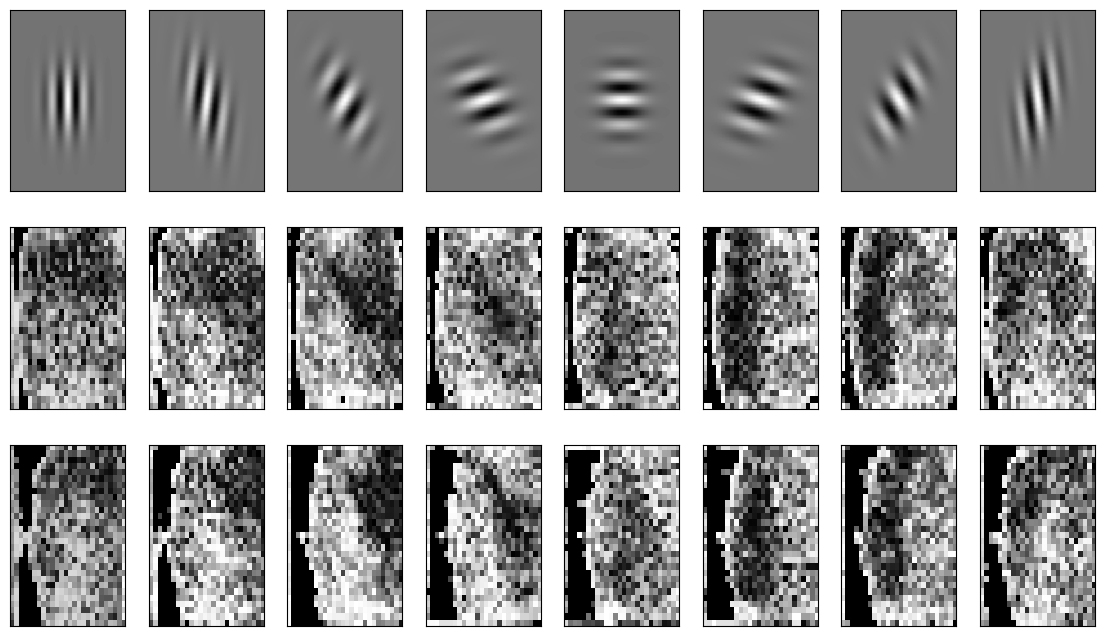

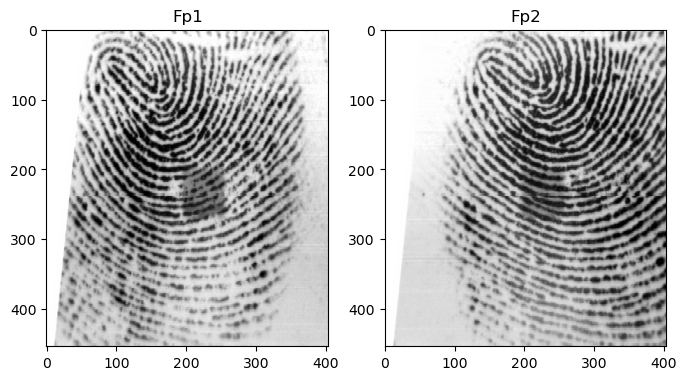

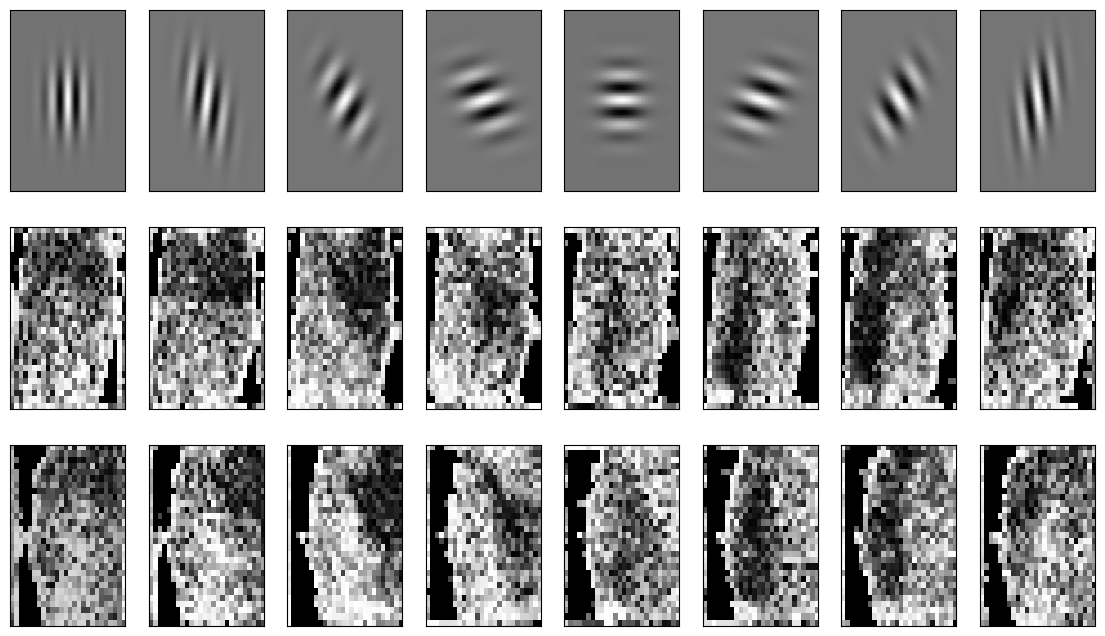

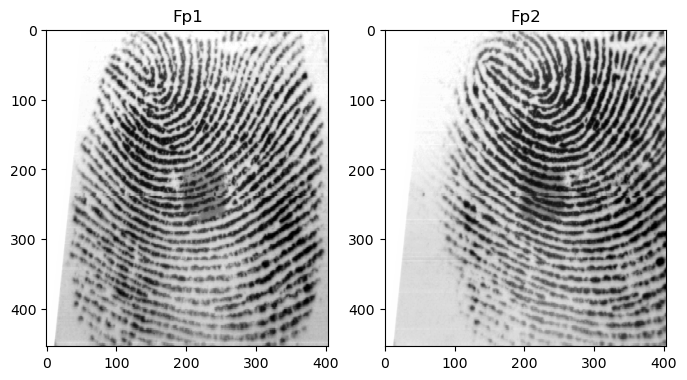

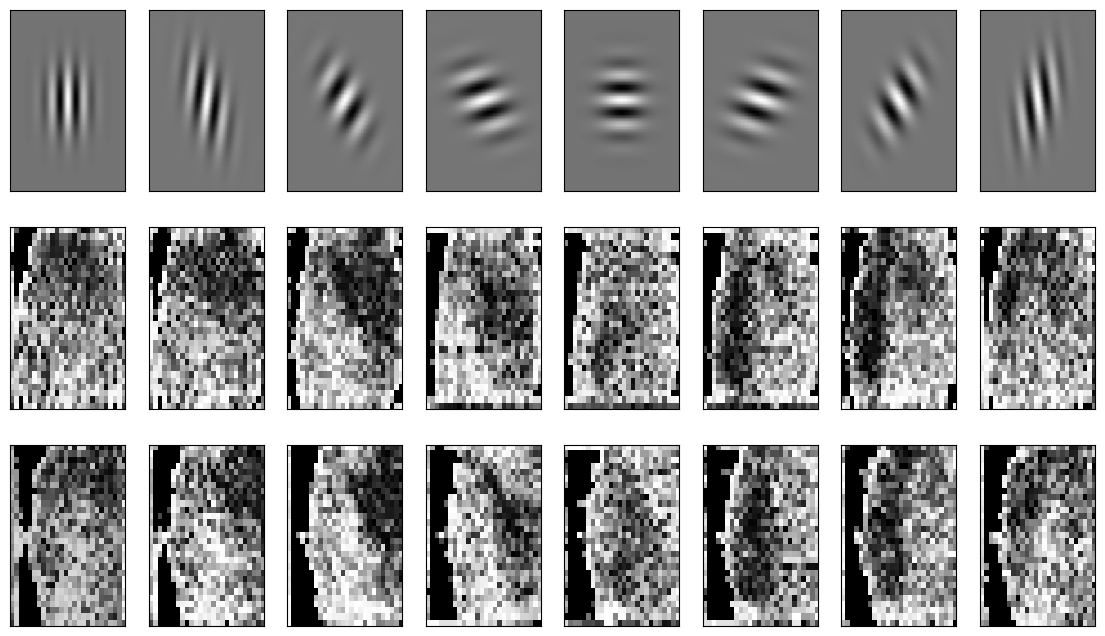

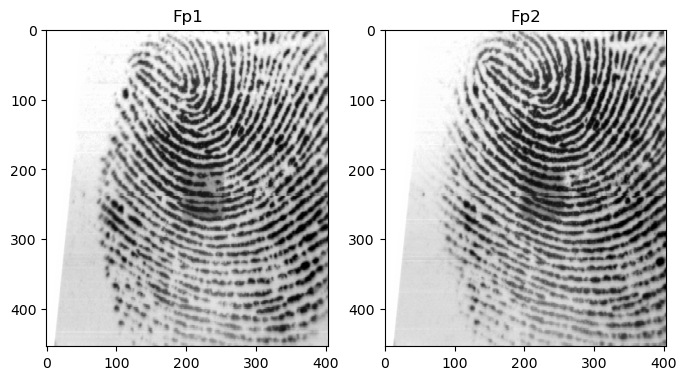

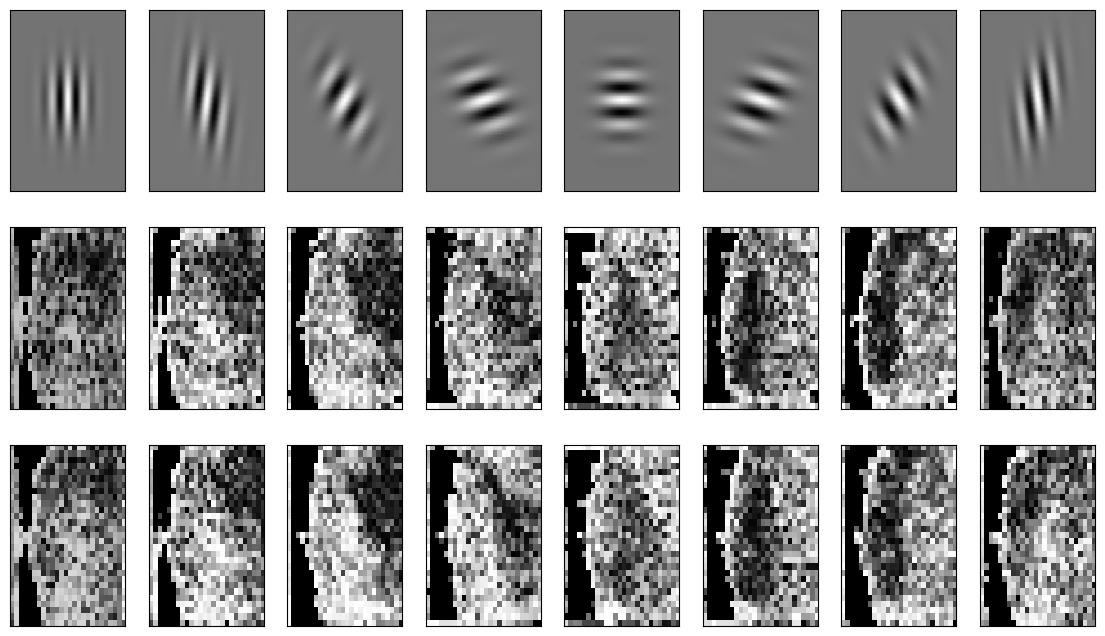

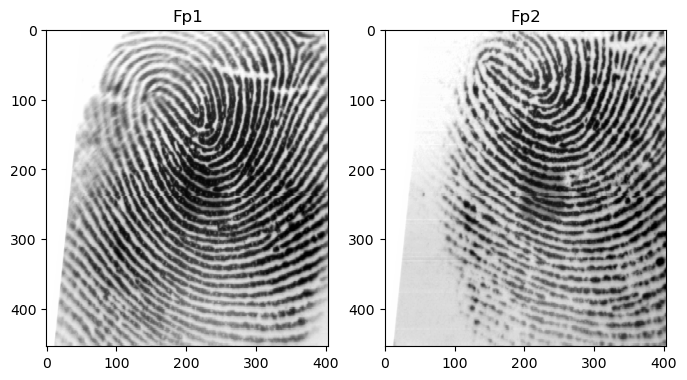

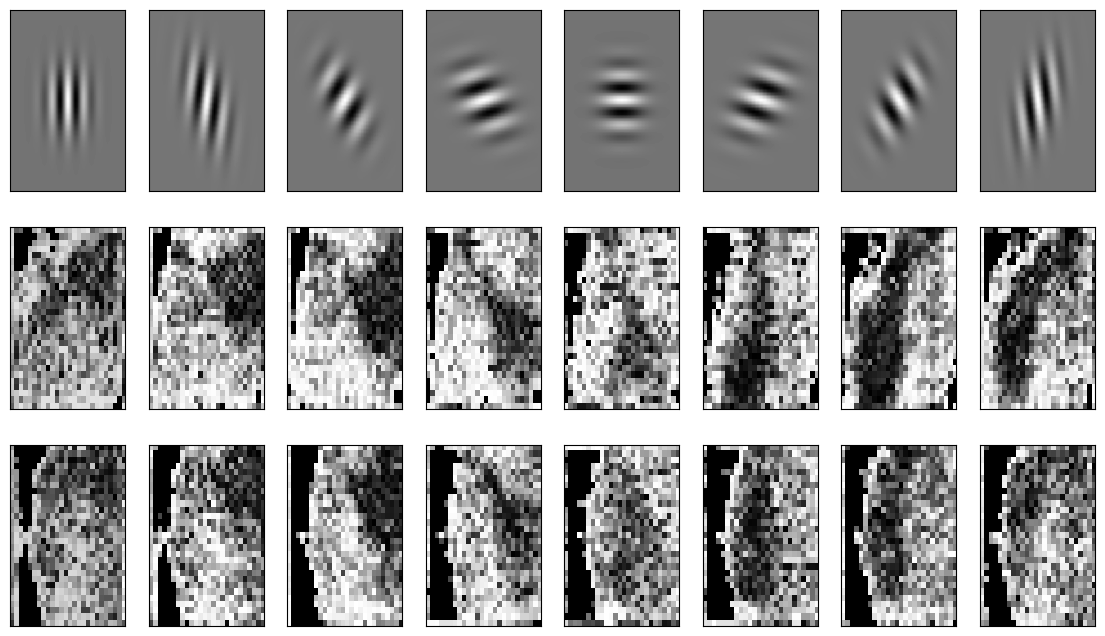

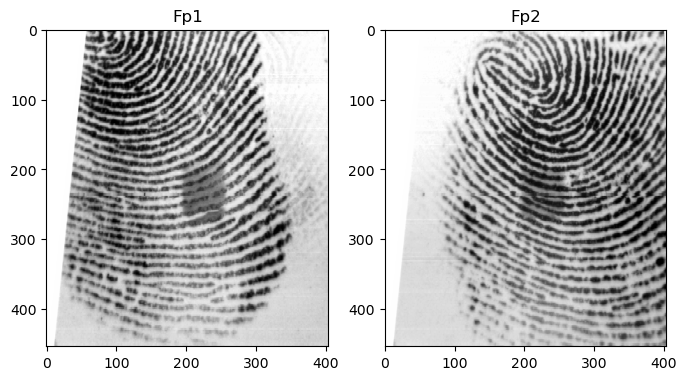

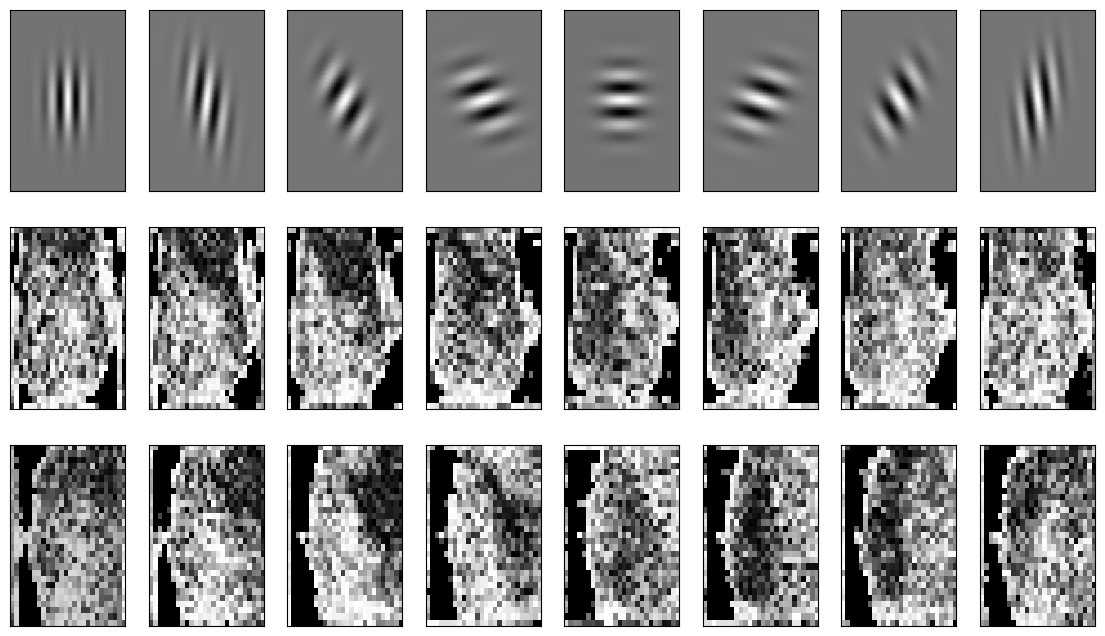

In [11]:
gabor_match_scores = {}
probe_img = img_as_ubyte(imread('fingerprints/r3.bmp', as_gray=True)) #change to r3 later?
for i in range(1,11):
    if i!=3:
        print(f"matching with fingerprints/r{i}")
        gallery_img = img_as_ubyte(imread(f'fingerprints/r{i}.bmp', as_gray=True))
        score = MatchGaborFeat(gallery_img, probe_img, plot_res=True)
        gabor_match_scores[f'fingerprints/r{i}'] = score
        print('Score using Gabor features: %.4f' % (score))

In [23]:
for k,v in gabor_match_scores.items():
    print(k,round(v,3))

fingerprints/r1 11.995
fingerprints/r2 12.162
fingerprints/r4 17.763
fingerprints/r5 16.39
fingerprints/r6 19.464
fingerprints/r7 16.897
fingerprints/r8 12.037
fingerprints/r9 16.701
fingerprints/r10 19.631


In [21]:
threshold1 = 15
threshold2 = 17

gabor_results = {threshold1: {'fp':0,'fn':0},threshold2: {'fp':0,'fn':0}}
for threshold in [threshold1,threshold2,threshold3]:
    for k,score in gabor_match_scores.items():
        if score<=threshold:
            gabor_results[threshold]['fp']+=1
        else:
             gabor_results[threshold]['fn']+=1

In [22]:
for k,v in gabor_results.items():
    print(k, v['fp'], v['fn'])

15 3 6
17 6 3
19 7 2


| Match Threshold Score 	| #FP 	| #FN 	|
|-----------------------	|-----	|-----	|
| 15                    	| 3   	| 6   	|
| 17                    	| 6   	| 3   	|
| 19                    	| 7   	| 2   	|

## Exercise 4

In [ ]:
gallery = []
prob_img = img_as_ubyte(imread(f'fingerprints/l3.bmp', as_gray=True))
prob_fp = fingerprint_processing(prob_img, block_size=12, threshold=0.1)
for i in range(1,11):
    img = img_as_ubyte(imread(f'fingerprints/r{i}.bmp', as_gray=True))
    fp = fingerprint_processing(img, block_size=12, threshold=0.1)
    gallery.append(fp)    

left_img  = img_as_ubyte(imread(f'fingerprints/l6.bmp', as_gray=True))
left_fp = fingerprint_processing(left_img, block_size=12, threshold=0.1)
gallery.append(left_fp)    
print("gallery initialization completed")    

In [ ]:
scores = {}
for i in range(0,len(gallery)):
    print(f"matching with gallery index {i}")
    imSkeletonAlign, minutiaArrayAlign = align2(gallery[i], probe_fp)
    probe_fp['imSkeletonAlign'] = imSkeletonAlign
    probe_fp['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(gallery[i], probe_fp, threshold2=match_threshold)
    score[i] = score
    print('score for minutiae: %.4f\n' % (score))

In [ ]:
sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1]))
for k,v in sorted_scores:
    print(f"index: {k} value:{v}")